<a href="https://colab.research.google.com/github/reallylongaddress/Kaggle/blob/main/playground_series_s3e5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [174]:
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score, make_scorer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer

In [2]:
data_path = ''

#kaggle
if (os.environ.get('KAGGLE_KERNEL_RUN_TYPE','')) or (os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == 'Interactive') or (os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == 'Batch'):
    print("Kaggle")  
    data_path = '/kaggle/input'    
    
#google colab
elif 'google.colab' in sys.modules:
    print('Google Colab')

    from google.colab import drive
    
    drive = drive.mount('/content/drive/')
    data_path = f'/content/drive/My Drive/Colab_Data/kaggle/playground-series-s3e5'
    
#localhost
elif os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == '':
    print('Localhost')
    data_path = './data'
    

Google Colab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk(data_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/content/drive/My Drive/Colab_Data/kaggle/playground-series-s3e5/test.csv
/content/drive/My Drive/Colab_Data/kaggle/playground-series-s3e5/train.csv
/content/drive/My Drive/Colab_Data/kaggle/playground-series-s3e5/simple_lr_no_scaling_output.csv
/content/drive/My Drive/Colab_Data/kaggle/playground-series-s3e5/simple_lr_scaled_output.csv
/content/drive/My Drive/Colab_Data/kaggle/playground-series-s3e5/linear_svc_scaling_output.csv
/content/drive/My Drive/Colab_Data/kaggle/playground-series-s3e5/knn_test_output_best_n.csv
/content/drive/My Drive/Colab_Data/kaggle/playground-series-s3e5/automl_output.csv
/content/drive/My Drive/Colab_Data/kaggle/playground-series-s3e5/y_baseline_output.csv
/content/drive/My Drive/Colab_Data/kaggle/playground-series-s3e5/simple_lr_output.csv
/content/drive/My Drive/Colab_Data/kaggle/playground-series-s3e5/simple_lr_best_preprocessing.csv
/content/drive/My Drive/Colab_Data/kaggle/playground-series-s3e5/h2o_pred.csv
/content/drive/My Drive/Colab_Data/kaggle/

In [4]:
train_val_df = pd.read_csv(f'{data_path}/train.csv', index_col='Id')
test_df = pd.read_csv(f'{data_path}/test.csv', index_col='Id')

train_val_df

#'full_train_df' because later this dataframe will be split into train and validate sets.  

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
Id,,,,,,,,,,,,
0,8.0,0.50,0.39,2.20,0.073,30.0,39.0,0.99572,3.33,0.77,12.1,6
1,9.3,0.30,0.73,2.30,0.092,30.0,67.0,0.99854,3.32,0.67,12.8,6
2,7.1,0.51,0.03,2.10,0.059,3.0,12.0,0.99660,3.52,0.73,11.3,7
3,8.1,0.87,0.22,2.60,0.084,11.0,65.0,0.99730,3.20,0.53,9.8,5
4,8.5,0.36,0.30,2.30,0.079,10.0,45.0,0.99444,3.20,1.36,9.5,6
...,...,...,...,...,...,...,...,...,...,...,...,...
2051,6.6,0.31,0.13,2.00,0.056,29.0,42.0,0.99388,3.52,0.87,12.0,7
2052,9.7,0.59,0.21,1.80,0.079,27.0,65.0,0.99745,3.14,0.58,9.4,5
2053,7.7,0.43,0.42,1.70,0.071,19.0,37.0,0.99258,3.32,0.77,12.5,8


In [5]:
train_val_df.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

In [6]:
test_df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
Id,,,,,,,,,,,
2056,7.2,0.510,0.01,2.0,0.077,31.0,54.0,0.99748,3.39,0.59,9.8
2057,7.2,0.755,0.15,2.0,0.102,14.0,35.0,0.99586,3.33,0.68,10.0
2058,8.4,0.460,0.40,2.0,0.065,21.0,50.0,0.99774,3.08,0.65,9.5
2059,8.0,0.470,0.40,1.8,0.056,14.0,25.0,0.99480,3.30,0.65,11.7
2060,6.5,0.340,0.32,2.1,0.044,8.0,94.0,0.99356,3.23,0.48,12.8
...,...,...,...,...,...,...,...,...,...,...,...
3423,8.8,0.745,0.18,2.7,0.084,41.0,115.0,0.99823,3.38,0.70,9.8
3424,15.6,0.240,0.55,2.9,0.062,11.0,25.0,0.99724,2.99,0.77,10.1
3425,7.3,0.760,0.00,2.2,0.095,6.0,19.0,0.99880,3.67,0.60,9.4


In [7]:
train_val_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000
mean,8.365175,0.527601,0.265058,2.398881,0.081856,16.955982,49.236868,0.996748,3.310569,0.641308,10.414972,5.720817
std,1.705390,0.173164,0.188267,0.858824,0.023729,10.009710,32.961141,0.001827,0.142321,0.137942,1.028825,0.853146
min,5.000000,0.180000,0.000000,1.200000,0.012000,1.000000,7.000000,0.990070,2.740000,0.390000,8.700000,3.000000
25%,7.200000,0.390000,0.090000,1.900000,0.071000,8.000000,22.000000,0.995600,3.200000,0.550000,9.500000,5.000000
50%,7.950000,0.520000,0.250000,2.200000,0.079000,16.000000,44.000000,0.996700,3.310000,0.610000,10.100000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,24.000000,65.000000,0.997800,3.390000,0.720000,11.000000,6.000000
max,15.900000,1.580000,0.760000,14.000000,0.414000,68.000000,289.000000,1.003690,3.780000,1.950000,14.000000,8.000000


In [8]:
from sklearn.metrics import cohen_kappa_score

In [9]:
# split full_train_df into X/y + train/validation
X_train_val = train_val_df.copy().drop(columns=['quality'])
y_train_val = train_val_df.copy()['quality']

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=1)

X_test = test_df.copy()

In [10]:
X_test

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
Id,,,,,,,,,,,
2056,7.2,0.510,0.01,2.0,0.077,31.0,54.0,0.99748,3.39,0.59,9.8
2057,7.2,0.755,0.15,2.0,0.102,14.0,35.0,0.99586,3.33,0.68,10.0
2058,8.4,0.460,0.40,2.0,0.065,21.0,50.0,0.99774,3.08,0.65,9.5
2059,8.0,0.470,0.40,1.8,0.056,14.0,25.0,0.99480,3.30,0.65,11.7
2060,6.5,0.340,0.32,2.1,0.044,8.0,94.0,0.99356,3.23,0.48,12.8
...,...,...,...,...,...,...,...,...,...,...,...
3423,8.8,0.745,0.18,2.7,0.084,41.0,115.0,0.99823,3.38,0.70,9.8
3424,15.6,0.240,0.55,2.9,0.062,11.0,25.0,0.99724,2.99,0.77,10.1
3425,7.3,0.760,0.00,2.2,0.095,6.0,19.0,0.99880,3.67,0.60,9.4


## Baseline Model

In [11]:
#assume mean train price for all MedHouseVal
train_mean_quality = int(y_train.mean())
train_mean_quality

y_pred_train_baseline = np.full((X_train.shape[0], 1), train_mean_quality, dtype=int)
y_pred_val_baseline = np.full((X_val.shape[0], 1), train_mean_quality, dtype=int)
y_pred_test_baseline = np.full((test_df.shape[0], 1), train_mean_quality, dtype=int)

In [12]:
val_baseline_score = cohen_kappa_score(y_val, y_pred_val_baseline, weights='quadratic')

print(f'cohen_kappa_score val_baseline_score: {val_baseline_score}')

cohen_kappa_score val_baseline_score: 0.0


In [13]:
#build the baseline submission for test set to get score
y_baseline_output = pd.DataFrame({'Id':test_df.index, 'quality':y_pred_test_baseline[:,0]})
y_baseline_output
y_baseline_output.to_csv(f'{data_path}/y_baseline_output.csv', index=False)
# Score: 0

## EDA

In [14]:
target='quality'

numerical_features = [col for col in X_train.select_dtypes(["int64", "float64","int32", "float32"]).columns if col not in [target]]
categorical_features = [col for col in X_train.select_dtypes("object").columns if col!=target]

print(f"Numerical Columns: {numerical_features}")
print(f"Categorical Columns: {categorical_features}")
print(f"Target Column: {target}")

Numerical Columns: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
Categorical Columns: []
Target Column: quality


No categorical columns

### Target Analysis

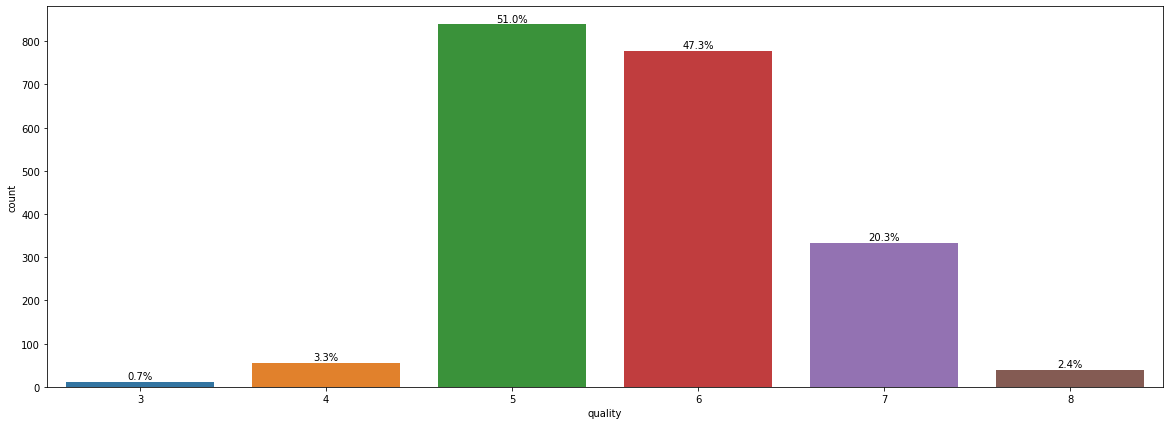

In [15]:
fig, ax = plt.subplots(figsize = (20,7))
sns.countplot(x=y_train.append(y_val))
# plt.title("Wine Quality Count")

total = len(y_train)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')

*  Lots of imbalance in the target class.  Potential solutions to 
**   Over/Under sampling
**   Stratified cross validation (will use this approach below)
* Values 3->8 convert 0->5


### Outliers/Boxplots

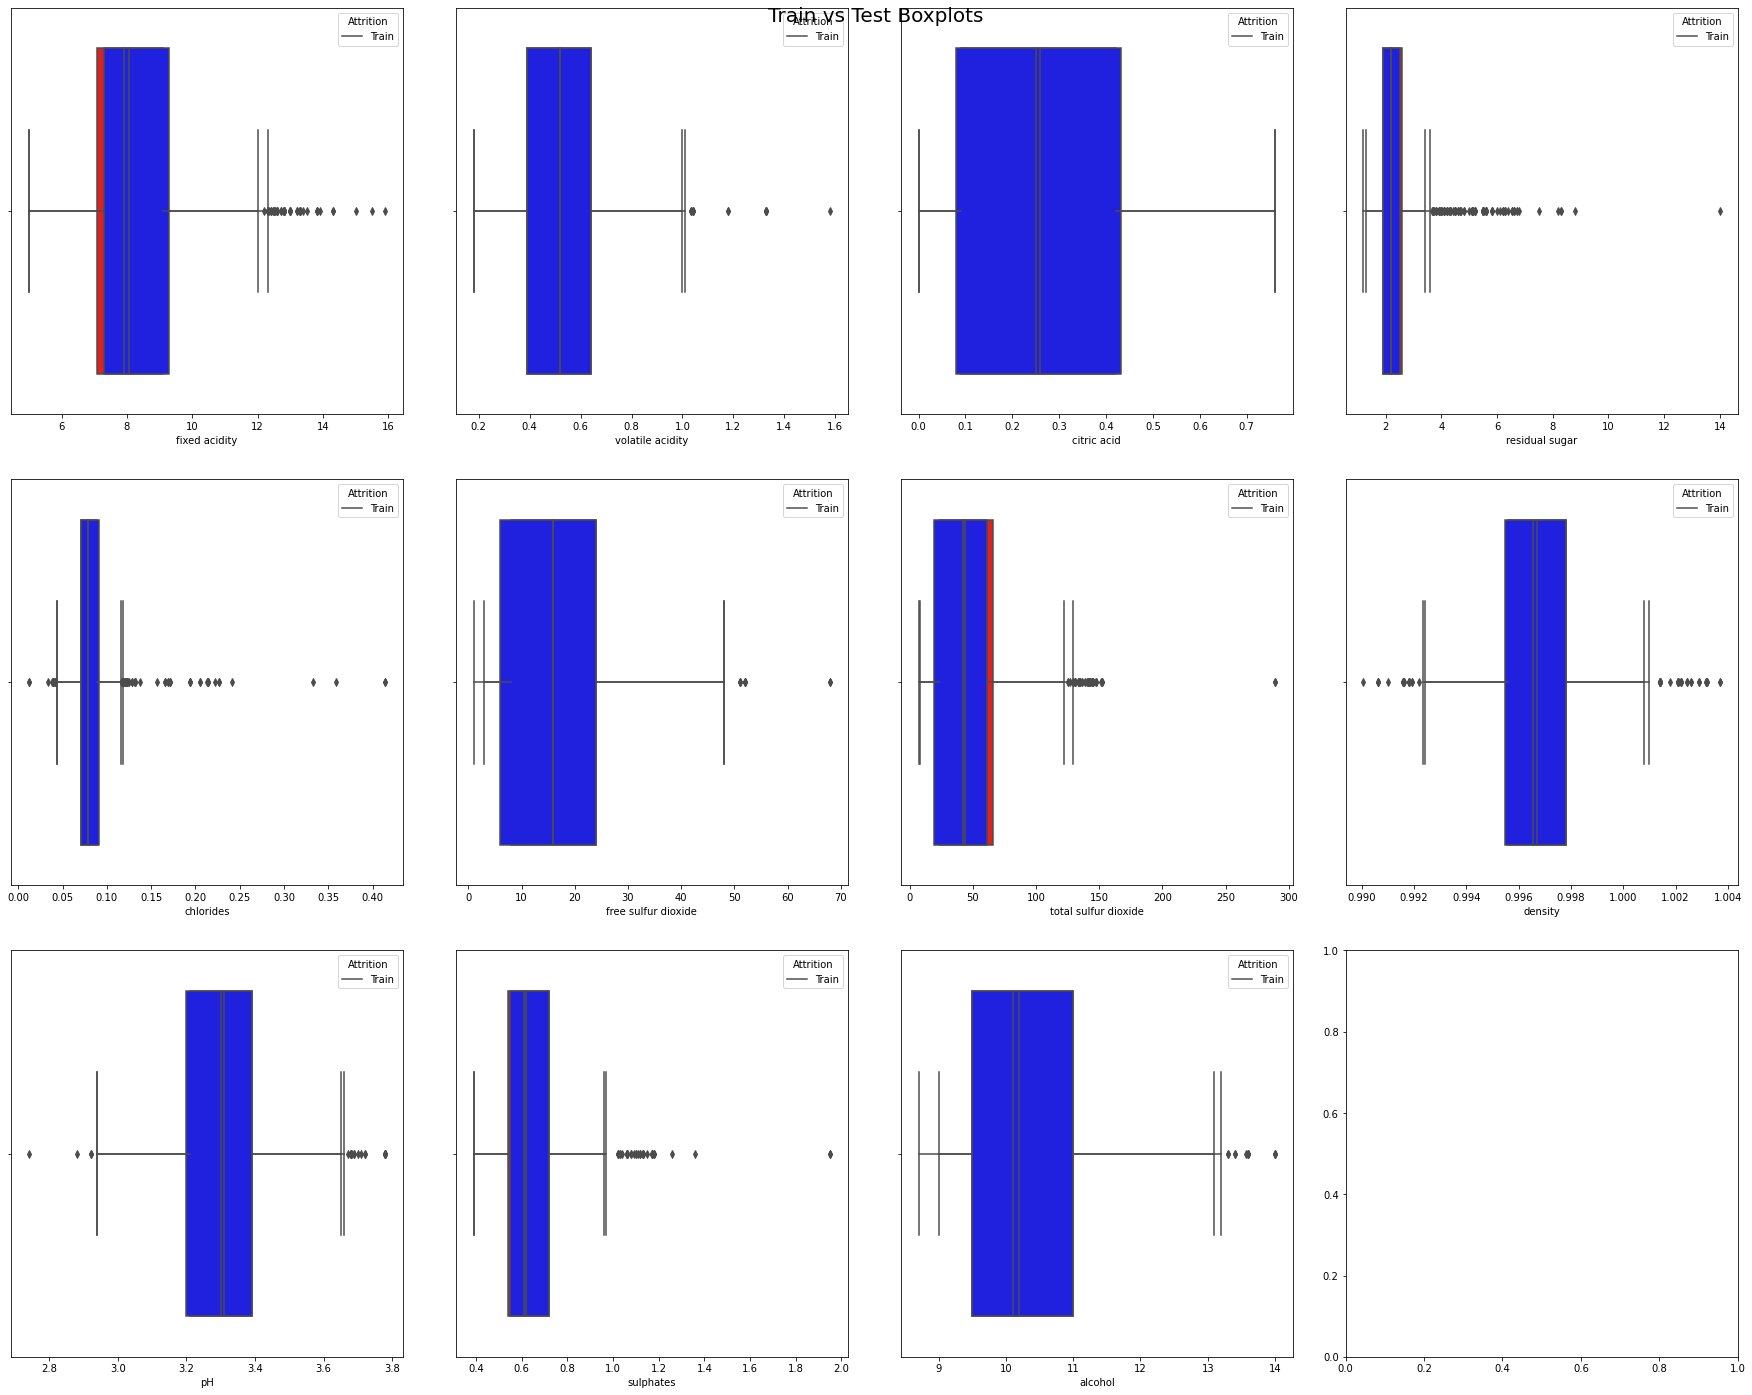

In [16]:
fig,ax = plt.subplots(int(np.ceil(len(numerical_features)/4)),4,figsize = (25,20))
ax = np.ravel(ax)

for i,col in enumerate(numerical_features):
    sns.boxplot(ax = ax[i], x = X_train[col], color= "red")
    sns.boxplot(ax = ax[i], x = X_val[col], color= "blue")

    ax[i].legend(title='Attrition', loc='upper right', labels=['Train'])
    
fig.suptitle("Train vs Test Boxplots",fontsize = 20)
plt.tight_layout(pad=3)
plt.show()

In [17]:
features_with_outliers = ['residual sugar', 'chlorides', 'fixed acidity', 'sulphates', 'density', 'pH', 'total sulfur dioxide']
features_with_outliers

['residual sugar',
 'chlorides',
 'fixed acidity',
 'sulphates',
 'density',
 'pH',
 'total sulfur dioxide']

Apply RobustScaler to these columns

### Skew/Kurtosis

In [18]:
skew_values = []
kurtosis_values = []

for feature in numerical_features:

  skew_values.append(X_train[feature].skew())
  kurtosis_values.append(X_train[feature].kurt())

skew_kurt_df = pd.DataFrame({'skew':np.abs(skew_values), 'kurtosis':np.abs(kurtosis_values), 'feature_name':numerical_features})
skew_kurt_df.sort_values(by='skew', ascending=False).head(6)

features_with_skew = ((skew_kurt_df[skew_kurt_df['skew'] > .99])['feature_name']).tolist()
features_with_kurtosis  = ((skew_kurt_df[skew_kurt_df['kurtosis'] > .99])['feature_name']).tolist()

print(f'features_with_skew: {features_with_skew}') 
print(f'features_with_kurtosis: {features_with_kurtosis}')

features_with_skew: ['fixed acidity', 'residual sugar', 'chlorides', 'total sulfur dioxide', 'sulphates']
features_with_kurtosis: ['volatile acidity', 'residual sugar', 'chlorides', 'total sulfur dioxide', 'sulphates']


In [19]:
skew_kurt_df.sort_values(by='kurtosis', ascending=False).head(5)

,skew,kurtosis,feature_name
4,5.566542,58.841841,chlorides
3,3.950455,27.984683,residual sugar
9,1.555721,6.637377,sulphates
6,1.297782,3.202709,total sulfur dioxide
1,0.635609,1.090080,volatile acidity


In [20]:
skew_kurt_df.sort_values(by='skew', ascending=False).head(5)

,skew,kurtosis,feature_name
4,5.566542,58.841841,chlorides
3,3.950455,27.984683,residual sugar
9,1.555721,6.637377,sulphates
6,1.297782,3.202709,total sulfur dioxide
0,0.993240,0.874678,fixed acidity


In [21]:
non_dist_cols = skew_kurt_df.sort_values(by='kurtosis', ascending=False).head(3)['feature_name'].tolist()
non_dist_cols

['chlorides', 'residual sugar', 'sulphates']

### Feature value distributions

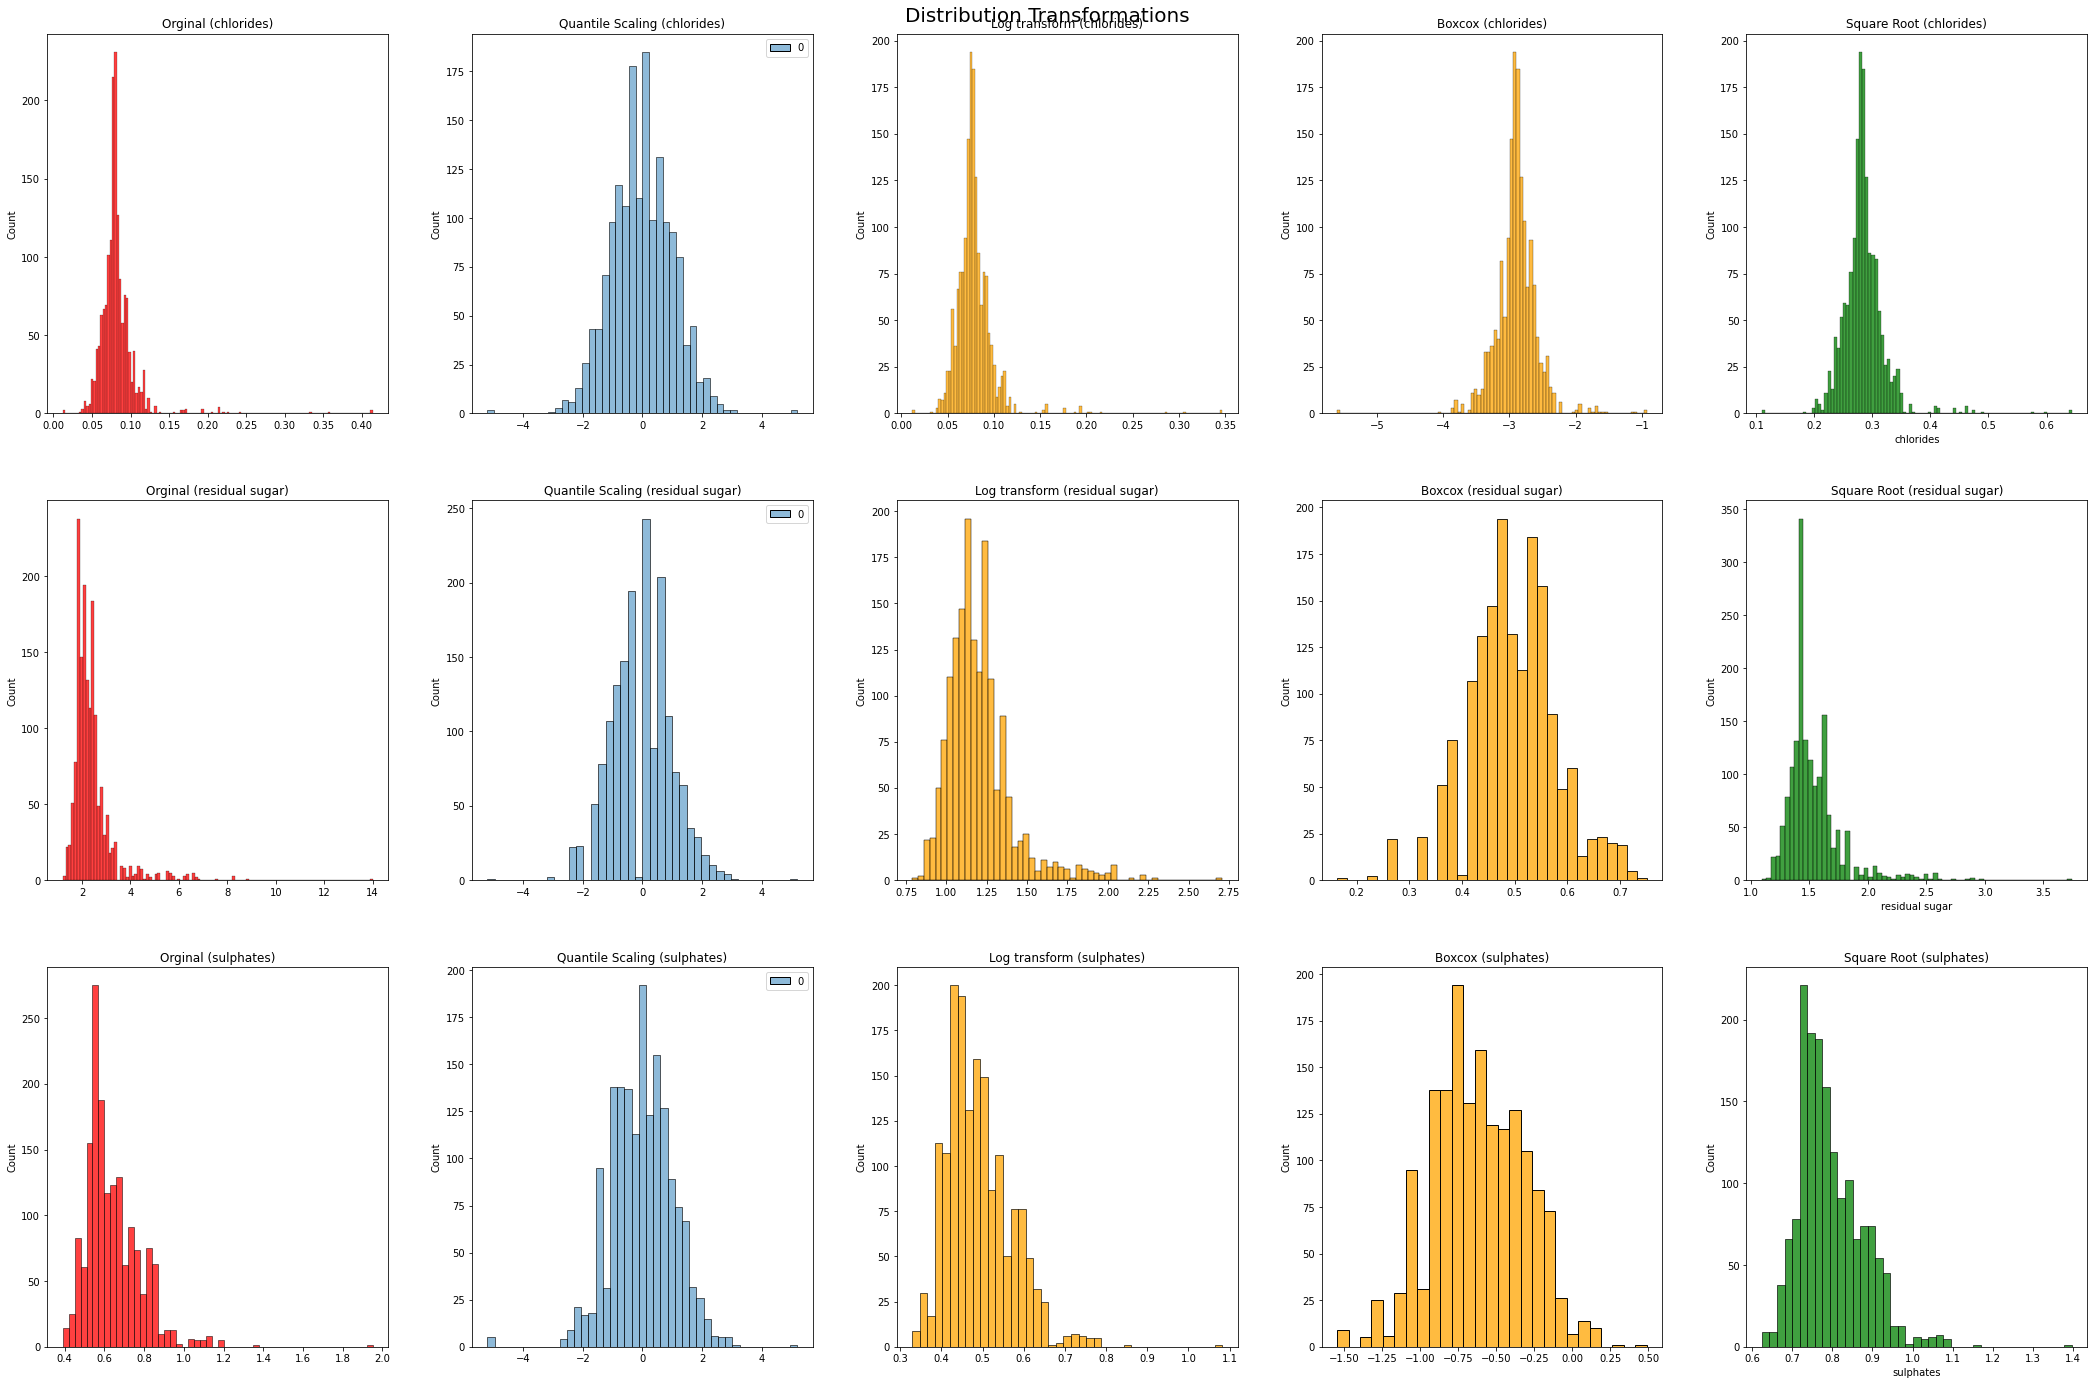

In [22]:
from scipy.stats import boxcox

fig,ax = plt.subplots(len(non_dist_cols),5, figsize = (30,20))
for i,col in enumerate(non_dist_cols):
    #scale
    scaler = QuantileTransformer(output_distribution="normal")
    quant_df = scaler.fit_transform(X_train[[col]])

    sns.histplot(x= X_train[col],ax= ax[i,0], color = "r")
    sns.histplot(quant_df,ax= ax[i,1] )
    sns.histplot(np.log1p(X_train[col]), ax = ax[i,2], color= "orange")
    try:
        sns.histplot(boxcox(X_train[col])[0], ax = ax[i,3], color= "orange")
    except:
        pass
    sns.histplot(np.sqrt(X_train[col]), ax = ax[i,4], color= "green")
    ax[i,0].set_title(f"Orginal ({col})")
    ax[i,0].set(xlabel=None)
    ax[i,1].set_title(f"Quantile Scaling ({col})")
    ax[i,2].set_title(f"Log transform ({col})")
    ax[i,2].set(xlabel=None)
    ax[i,3].set_title(f"Boxcox ({col})")
    ax[i,4].set_title(f"Square Root ({col})")
plt.suptitle("Distribution Transformations",fontsize = 20)
plt.tight_layout(pad = 4)
plt.show()

Use Quintile Scaler to correct distribution

## Preprocessing

### Encode target

In [23]:
do_target_encoding = True

if do_target_encoding:

  #get the unique target values
  target_categories = pd.DataFrame(y_train.unique())

  #sort target values by increasing value
  target_categories = target_categories.sort_values(by=0)

  #reset index 0->(n-1)
  target_categories = target_categories.reset_index(drop=True)
  target_categories = dict(zip(target_categories[0], target_categories.index))
  inv_target_categories = inv_map = {v: k for k, v in target_categories.items()}

  y_train = y_train.map(target_categories)
  y_val = y_val.map(target_categories)

### Outliers

In [24]:
features_with_outliers

['residual sugar',
 'chlorides',
 'fixed acidity',
 'sulphates',
 'density',
 'pH',
 'total sulfur dioxide']

In [25]:
do_outliers = True

if do_outliers:
  robust_scaler = RobustScaler()
  robust_scaler.fit(X_train[features_with_outliers])

  X_train[features_with_outliers] = robust_scaler.transform(X_train[features_with_outliers])
  X_val[features_with_outliers] = robust_scaler.transform(X_val[features_with_outliers])
  X_test[features_with_outliers] = robust_scaler.transform(X_test[features_with_outliers])

In [26]:
X_train

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
Id,,,,,,,,,,,
563,2.00,0.685,0.49,0.571429,0.333333,5.0,-0.581395,0.672727,-1.611111,-0.666667,10.1
17,-0.15,0.560,0.28,0.285714,-0.111111,16.0,0.976744,0.081818,-0.500000,0.166667,9.8
248,1.00,0.450,0.24,-0.714286,0.111111,37.5,0.209302,0.090909,-0.666667,-0.944444,9.5
1739,-0.55,0.640,0.21,-0.142857,0.777778,9.0,-0.279070,0.331818,2.055556,0.666667,9.5
1412,-0.05,0.690,0.06,-0.571429,-0.055556,31.0,-0.139535,-0.763636,0.444444,1.777778,11.9
...,...,...,...,...,...,...,...,...,...,...,...
960,-0.65,0.340,0.29,0.285714,1.055556,15.0,-0.255814,-1.200000,0.722222,0.055556,11.9
905,-0.40,0.510,0.17,-0.142857,-0.111111,25.0,0.953488,-0.672727,0.833333,-0.111111,10.1
1096,-0.50,0.360,0.31,-0.428571,-0.277778,26.0,0.488372,-1.295455,0.222222,1.166667,11.9


### Skewness & Kurtosis

In [27]:
do_fix_distribution = True

if do_fix_distribution:
  quant_trans = QuantileTransformer(output_distribution="normal")
  quant_trans.fit(X_train[non_dist_cols])

  X_train[non_dist_cols] = quant_trans.transform(X_train[non_dist_cols])
  X_val[non_dist_cols] = quant_trans.transform(X_val[non_dist_cols])
  X_test[non_dist_cols] = quant_trans.transform(X_test[non_dist_cols])

### Scaling/Transforming Data
Run other columns through StandardScaler

In [28]:
do_standard_scaler = True

if do_standard_scaler:
  ss_columns = list(set(X_train.columns) - set(non_dist_cols) - set(features_with_outliers))
  standard_scaler = StandardScaler()
  standard_scaler.fit(X_train[ss_columns])

  X_train[ss_columns] = standard_scaler.transform(X_train[ss_columns])
  X_val[ss_columns] = standard_scaler.transform(X_val[ss_columns])
  X_test[ss_columns] = standard_scaler.transform(X_test[ss_columns])


a ss_columns: ['alcohol', 'citric acid', 'free sulfur dioxide', 'volatile acidity']


### Correlation reduction

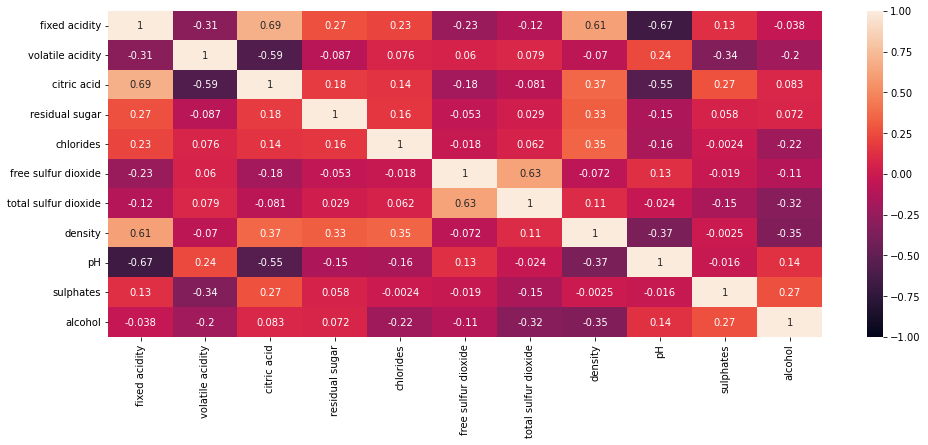

In [29]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(X_train.corr(), vmin=-1, vmax=1, annot=True)

In [30]:
from sklearn.decomposition import PCA

In [31]:
do_pca = True

if do_pca:
  # train_df_2 = X_train.copy()
  # test_df_2 = X_test.copy()

  print(f'{X_train.shape}, {X_val.shape}')

  pca_cols = ["pH","fixed acidity"]
  pca_ = PCA(n_components=1 ,whiten= False)
  X_train["pca_1"] = pca_.fit_transform(X_train[pca_cols])
  X_val["pca_1"] = pca_.fit_transform(X_val[pca_cols])
  X_test["pca_1"] = pca_.fit_transform(X_test[pca_cols])

  for cols in pca_cols:
      for df in [X_train, X_val, X_test]:
          df.drop(cols, axis=1, inplace=True)

  print(f'{X_train.shape}, {X_val.shape}')

  

(1644, 11), (412, 11)
(1644, 10), (412, 10)


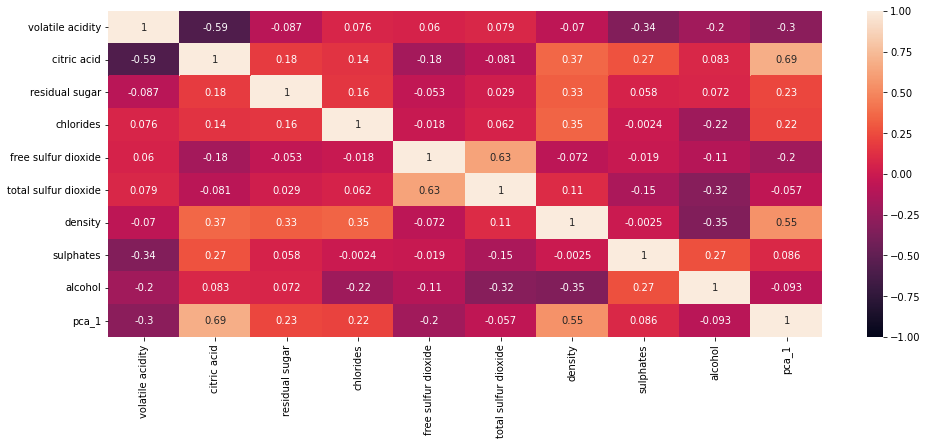

In [32]:
if do_pca:
  plt.figure(figsize=(16, 6))
  heatmap = sns.heatmap(X_train.corr(), vmin=-1, vmax=1, annot=True)

### Imbalanced Classes

In [33]:
from imblearn.over_sampling import SMOTE

do_smote = True
if do_smote:
  #only do this on the train set
  X_train, y_train = SMOTE().fit_resample(X_train, y_train)


### Combine preprocessing into a single, configurable function

In [114]:
def process_data(x_train, y_train, x_val, y_val, x_test,
                 encode_target=True,
                 outliers=True,
                 skew_kurt=True,
                 transform=True,
                 corr_reduction=True,
                 imbalanced_classes=True):
  
  _x_train = x_train.copy()
  _y_train = y_train.copy()
  _x_val = x_val.copy()
  _y_val = y_val.copy()
  _x_test = x_test.copy()

  if encode_target:

    #get the unique target values
    target_categories = pd.DataFrame(_y_train.unique())

    #sort target values by increasing value
    target_categories = target_categories.sort_values(by=0)

    #reset index 0->(n-1)
    target_categories = target_categories.reset_index(drop=True)
    target_categories = dict(zip(target_categories[0], target_categories.index))

    _y_train = _y_train.map(target_categories)
    _y_val = _y_val.map(target_categories)

  if outliers:
    robust_scaler = RobustScaler()
    robust_scaler.fit(_x_train[features_with_outliers])

    # print(f'features_with_outliers: {features_with_outliers}')
    _x_train[features_with_outliers] = robust_scaler.transform(_x_train[features_with_outliers])
    _x_val[features_with_outliers] = robust_scaler.transform(_x_val[features_with_outliers])
    _x_test[features_with_outliers] = robust_scaler.transform(_x_test[features_with_outliers])

  if skew_kurt:

    quant_trans = QuantileTransformer(output_distribution="normal")
    quant_trans.fit(_x_train[non_dist_cols])
    # print(f'non_dist_cols: {non_dist_cols}')

    _x_train[non_dist_cols] = quant_trans.transform(_x_train[non_dist_cols])
    _x_val[non_dist_cols] = quant_trans.transform(_x_val[non_dist_cols])
    _x_test[non_dist_cols] = quant_trans.transform(_x_test[non_dist_cols])

  if transform:
    
    ss_columns = list(set(X_train.columns) - set(non_dist_cols) - set(features_with_outliers) - set(['pca_1']))
    standard_scaler = StandardScaler()
    # standard_scaler = RobustScaler()
    standard_scaler.fit(_x_train[ss_columns])

    _x_train[ss_columns] = standard_scaler.transform(_x_train[ss_columns])
    _x_val[ss_columns] = standard_scaler.transform(_x_val[ss_columns])
    _x_test[ss_columns] = standard_scaler.transform(_x_test[ss_columns])

  if corr_reduction:

    pca_cols = ["pH","fixed acidity"]
    n_components = 1
    pca_ = PCA(n_components=n_components ,whiten= False)
    _x_train["pca_1"] = pca_.fit_transform(_x_train[pca_cols])
    _x_val["pca_1"] = pca_.fit_transform(_x_val[pca_cols])
    _x_test["pca_1"] = pca_.fit_transform(_x_test[pca_cols])

    for cols in pca_cols:
        for df in [_x_train, _x_val, _x_test]:
            df.drop(cols, axis=1, inplace=True)

  if imbalanced_classes:
    #only do this on the train set
    _x_train, _y_train = SMOTE().fit_resample(_x_train, _y_train)

  return _x_train, _y_train, _x_val, _y_val, _x_test


## Modeling

### Baseline model
Logistic regression

In [115]:
X_train_val = train_val_df.copy().drop(columns=['quality'])
y_train_val = train_val_df.copy()['quality']

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=1)

X_test = test_df.copy()

simple_lr = LogisticRegression(max_iter=10000)
simple_lr.fit(X_train, y_train)

val_lr_pred = simple_lr.predict(X_val)
val_lr_score = cohen_kappa_score(y_val, val_lr_pred, weights='quadratic')
print(f'cohen_kappa_score val_lr_score (not scaled): {val_lr_score}')

cohen_kappa_score val_lr_score (not scaled): 0.4015721120984278


In [116]:
X_train

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
Id,,,,,,,,,,,
563,11.9,0.685,0.49,2.6,0.085,5.0,19.0,0.99820,3.02,0.49,10.1
17,7.6,0.560,0.28,2.4,0.077,16.0,86.0,0.99690,3.22,0.64,9.8
248,9.9,0.450,0.24,1.7,0.081,37.5,53.0,0.99692,3.19,0.44,9.5
1739,6.8,0.640,0.21,2.1,0.093,9.0,32.0,0.99745,3.68,0.73,9.5
1412,7.8,0.690,0.06,1.8,0.078,31.0,38.0,0.99504,3.39,0.93,11.9
...,...,...,...,...,...,...,...,...,...,...,...
960,6.6,0.340,0.29,2.4,0.098,15.0,33.0,0.99408,3.44,0.62,11.9
905,7.1,0.510,0.17,2.1,0.077,25.0,85.0,0.99524,3.46,0.59,10.1
1096,6.9,0.360,0.31,1.9,0.074,26.0,65.0,0.99387,3.35,0.82,11.9


### Simple Logistic Regression

In [117]:
inputs = [
  # {'encode_target':True, 'outliers':True, 'skew_kurt':True, 'transform':True, 'corr_reduction':True, 'imbalanced_classes':True},
  # {'encode_target':True, 'outliers':True, 'skew_kurt':True, 'transform':True, 'corr_reduction':False, 'imbalanced_classes':True},
  # {'encode_target':True, 'outliers':True, 'skew_kurt':True, 'transform':True, 'corr_reduction':True, 'imbalanced_classes':False},
  # {'encode_target':True, 'outliers':True, 'skew_kurt':True, 'transform':True, 'corr_reduction':False, 'imbalanced_classes':False},
  # {'encode_target':True, 'outliers':True, 'skew_kurt':False, 'transform':True, 'corr_reduction':False, 'imbalanced_classes':False},
  # {'encode_target':True, 'outliers':False, 'skew_kurt':False, 'transform':True, 'corr_reduction':False, 'imbalanced_classes':False},
  # {'encode_target':False, 'outliers':False, 'skew_kurt':False, 'transform':True, 'corr_reduction':False, 'imbalanced_classes':False},
  # {'encode_target':False, 'outliers':True, 'skew_kurt':False, 'transform':True, 'corr_reduction':False, 'imbalanced_classes':True},
  # {'encode_target':True, 'outliers':False, 'skew_kurt':False, 'transform':True, 'corr_reduction':False, 'imbalanced_classes':True},
  # {'encode_target':False, 'outliers':False, 'skew_kurt':False, 'transform':True, 'corr_reduction':False, 'imbalanced_classes':False},
  {'encode_target':False, 'outliers':True, 'skew_kurt':True, 'transform':True, 'corr_reduction':False, 'imbalanced_classes':False},
  # {'encode_target':True, 'outliers':False, 'skew_kurt':False, 'transform':False, 'corr_reduction':False, 'imbalanced_classes':True},
  # {'encode_target':True, 'outliers':False, 'skew_kurt':False, 'transform':False, 'corr_reduction':False, 'imbalanced_classes':True},
]

best_score = 0
best_model = None
test_data = None

X_train_val = train_val_df.copy().drop(columns=['quality'])
y_train_val = train_val_df.copy()['quality']

for input in inputs:

  X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=1)
  X_test = test_df.copy()

  a_train, aa_train, b_val, bb_val, c_test = process_data(X_train, y_train, X_val, y_val, X_test,
                                                          encode_target=input.get('encode_target'),
                                                          outliers=input.get('outliers'),
                                                          skew_kurt=input.get('skew_kurt'),
                                                          transform=input.get('transform'),
                                                          corr_reduction=input.get('corr_reduction'),
                                                          imbalanced_classes=input.get('imbalanced_classes'))

  simple_lr = LogisticRegression(max_iter=10000)
  simple_lr.fit(a_train, aa_train)

  val_lr_pred_scaled = simple_lr.predict(b_val)
  val_lr_score_scaled = cohen_kappa_score(bb_val, val_lr_pred_scaled, weights='quadratic')

  if val_lr_score_scaled > best_score:
    best_score = val_lr_score_scaled
    best_model = simple_lr
    test_data = c_test.copy()

  print(f'({round(val_lr_score_scaled, 3)}):::{input}')
  print('--'*10)
print(f'cohen_kappa_score BEST val score: ({round(best_score, 3)})')


(0.437):::{'encode_target': False, 'outliers': True, 'skew_kurt': True, 'transform': True, 'corr_reduction': False, 'imbalanced_classes': False}
--------------------
cohen_kappa_score BEST val score: (0.437)


In [118]:
def testModelWithPreprocessors(model):
  inputs = [
    # {'encode_target':True, 'outliers':True, 'skew_kurt':True, 'transform':True, 'corr_reduction':True, 'imbalanced_classes':True},
    # {'encode_target':True, 'outliers':True, 'skew_kurt':True, 'transform':True, 'corr_reduction':False, 'imbalanced_classes':True},
    # {'encode_target':True, 'outliers':True, 'skew_kurt':True, 'transform':True, 'corr_reduction':True, 'imbalanced_classes':False},
    # {'encode_target':True, 'outliers':True, 'skew_kurt':True, 'transform':True, 'corr_reduction':False, 'imbalanced_classes':False},
    # {'encode_target':True, 'outliers':True, 'skew_kurt':False, 'transform':True, 'corr_reduction':False, 'imbalanced_classes':False},
    # {'encode_target':True, 'outliers':False, 'skew_kurt':False, 'transform':True, 'corr_reduction':False, 'imbalanced_classes':False},
    {'encode_target':False, 'outliers':False, 'skew_kurt':False, 'transform':False, 'corr_reduction':False, 'imbalanced_classes':False},
    {'encode_target':False, 'outliers':False, 'skew_kurt':False, 'transform':False, 'corr_reduction':True, 'imbalanced_classes':False},
    # {'encode_target':False, 'outliers':True, 'skew_kurt':False, 'transform':True, 'corr_reduction':False, 'imbalanced_classes':True},
    # {'encode_target':True, 'outliers':False, 'skew_kurt':False, 'transform':True, 'corr_reduction':False, 'imbalanced_classes':True},
    {'encode_target':False, 'outliers':False, 'skew_kurt':False, 'transform':True, 'corr_reduction':True, 'imbalanced_classes':False},
    {'encode_target':False, 'outliers':False, 'skew_kurt':False, 'transform':True, 'corr_reduction':False, 'imbalanced_classes':False},
    {'encode_target':False, 'outliers':True, 'skew_kurt':True, 'transform':True, 'corr_reduction':True, 'imbalanced_classes':False},
    {'encode_target':False, 'outliers':True, 'skew_kurt':True, 'transform':True, 'corr_reduction':False, 'imbalanced_classes':False},
    # {'encode_target':True, 'outliers':False, 'skew_kurt':False, 'transform':False, 'corr_reduction':False, 'imbalanced_classes':True},
    # {'encode_target':True, 'outliers':False, 'skew_kurt':False, 'transform':False, 'corr_reduction':False, 'imbalanced_classes':True},
  ]

  best_score = 0
  best_model = None
  test_data = None

  X_train_val = train_val_df.copy().drop(columns=['quality'])
  y_train_val = train_val_df.copy()['quality']

  for input in inputs:

    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=1)
    X_test = test_df.copy()

    a_train, aa_train, b_val, bb_val, c_test = process_data(X_train, y_train, X_val, y_val, X_test,
                                                            encode_target=input.get('encode_target'),
                                                            outliers=input.get('outliers'),
                                                            skew_kurt=input.get('skew_kurt'),
                                                            transform=input.get('transform'),
                                                            corr_reduction=input.get('corr_reduction'),
                                                            imbalanced_classes=input.get('imbalanced_classes'))

    model.fit(a_train, aa_train)

    val_pred = model.predict(b_val)
    val_pred_score = cohen_kappa_score(bb_val, val_pred, weights='quadratic')

    if val_pred_score > best_score:
      best_score = val_pred_score
      best_model = model

    print(f'({round(val_pred_score, 3)}):::{input}')
    print('--'*10)
  print(f'dbd_cohen_kappa_score BEST val score {model}: ({round(best_score, 3)})')


In [119]:
# y_test_pred = pd.Series(best_model.predict(test_data))
# y_test_simple_lr_output = pd.DataFrame({'Id':test_df.index, 'quality':y_test_pred})

# y_test_simple_lr_output.to_csv(f'{data_path}/simple_lr_best_preprocessing.csv', index=False)


In [202]:
def cleanPreprocessedDataFrame(params = None):
  X_train_val = train_val_df.copy().drop(columns=['quality'])
  y_train_val = train_val_df.copy()['quality']

  X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=1)
  X_test = test_df.copy()
  # print(f'a: {X_train.shape}::{X_test.shape}')

  input =  {'encode_target':False, 'outliers':True, 'skew_kurt':True, 'transform':True, 'corr_reduction':False, 'imbalanced_classes':False}
  if params is not None:
    input = params

  X_train_2, y_train_2, X_val_2, y_val_2, X_test_2 = process_data(X_train, y_train, X_val, y_val, X_test,
                                                          encode_target=input.get('encode_target'),
                                                          outliers=input.get('outliers'),
                                                          skew_kurt=input.get('skew_kurt'),
                                                          transform=input.get('transform'),
                                                          corr_reduction=input.get('corr_reduction'),
                                                          imbalanced_classes=input.get('imbalanced_classes'))

  return X_train_2, y_train_2, X_val_2, y_val_2, X_test_2

### Basic LogisticRegression

In [121]:
X_train, y_train, X_val, y_val, X_test = cleanPreprocessedDataFrame()


In [122]:
#VALIDATION
model_string = "LogisticRegression"
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

val_pred = model.predict(X_val)
val_score = cohen_kappa_score(y_val, val_pred, weights='quadratic')
print(f'VAL cohen_kappa_score {model_string}: {round(val_score, 3)}')
# Score standard scaler: 0.437
# Score MinMax scaler: 0.415
# Score Robust scaler: 0.437
#------------
#TEST/SUBMISSION

test_pred = model.predict(X_test)
test_pred = pd.DataFrame({'Id':test_df.index, 'quality':test_pred})

test_pred.to_csv(f'{data_path}/test_pred_{model_string}.csv', index=False)

VAL cohen_kappa_score LogisticRegression: 0.437


### LinearSVC

In [123]:
from sklearn.svm import LinearSVC

#VALIDATION
model_string = "LinearSVC"
model = LinearSVC(max_iter=10000)
model.fit(X_train, y_train)

val_pred = model.predict(X_val)
val_score = cohen_kappa_score(y_val, val_pred, weights='quadratic')
print(f'VAL cohen_kappa_score {model_string}: {round(val_score, 3)}')
# Score standard scaler: 0.345
# Score MinMax scaler: 0.345
# Score Robust scaler: 0.345
#------------
#TEST/SUBMISSION

test_pred = model.predict(X_test)
test_pred = pd.DataFrame({'Id':test_df.index, 'quality':test_pred})

test_pred.to_csv(f'{data_path}/test_pred_{model_string}.csv', index=False)

VAL cohen_kappa_score LinearSVC: 0.345


### SVC

In [135]:
from sklearn.svm import SVC

#VALIDATION
model_string = "SVC"
model = SVC(kernel = 'rbf', random_state = 0)
model.fit(X_train, y_train)

val_pred = model.predict(X_val)
val_score = cohen_kappa_score(y_val, val_pred, weights='quadratic')
print(f'VAL cohen_kappa_score {model_string}: {round(val_score, 3)}')
# Score standard scaler: 0.425
#------------
#TEST/SUBMISSION

test_pred = model.predict(X_test)
test_pred = pd.DataFrame({'Id':test_df.index, 'quality':test_pred})

test_pred.to_csv(f'{data_path}/test_pred_{model_string}.csv', index=False)

VAL cohen_kappa_score SVC: 0.407


In [136]:
model = RandomForestClassifier()
testModelWithPreprocessors(model)

(0.401):::{'encode_target': False, 'outliers': False, 'skew_kurt': False, 'transform': False, 'corr_reduction': False, 'imbalanced_classes': False}
--------------------
(0.425):::{'encode_target': False, 'outliers': False, 'skew_kurt': False, 'transform': False, 'corr_reduction': True, 'imbalanced_classes': False}
--------------------
(0.421):::{'encode_target': False, 'outliers': False, 'skew_kurt': False, 'transform': True, 'corr_reduction': True, 'imbalanced_classes': False}
--------------------
(0.405):::{'encode_target': False, 'outliers': False, 'skew_kurt': False, 'transform': True, 'corr_reduction': False, 'imbalanced_classes': False}
--------------------
(0.416):::{'encode_target': False, 'outliers': True, 'skew_kurt': True, 'transform': True, 'corr_reduction': True, 'imbalanced_classes': False}
--------------------
(0.406):::{'encode_target': False, 'outliers': True, 'skew_kurt': True, 'transform': True, 'corr_reduction': False, 'imbalanced_classes': False}
------------------

### GaussianNB

In [137]:
from sklearn.naive_bayes import GaussianNB

#VALIDATION
model_string = "GaussianNB"
model = GaussianNB()
model.fit(X_train, y_train)

val_pred = model.predict(X_val)
val_score = cohen_kappa_score(y_val, val_pred, weights='quadratic')
print(f'VAL cohen_kappa_score {model_string}: {round(val_score, 3)}')
# Score standard scaler: 0.452
#------------
#TEST/SUBMISSION

test_pred = model.predict(X_test)
test_pred = pd.DataFrame({'Id':test_df.index, 'quality':test_pred})

test_pred.to_csv(f'{data_path}/test_pred_{model_string}.csv', index=False)

VAL cohen_kappa_score GaussianNB: 0.392


In [138]:
model = RandomForestClassifier()
testModelWithPreprocessors(model)

(0.42):::{'encode_target': False, 'outliers': False, 'skew_kurt': False, 'transform': False, 'corr_reduction': False, 'imbalanced_classes': False}
--------------------
(0.395):::{'encode_target': False, 'outliers': False, 'skew_kurt': False, 'transform': False, 'corr_reduction': True, 'imbalanced_classes': False}
--------------------
(0.402):::{'encode_target': False, 'outliers': False, 'skew_kurt': False, 'transform': True, 'corr_reduction': True, 'imbalanced_classes': False}
--------------------
(0.452):::{'encode_target': False, 'outliers': False, 'skew_kurt': False, 'transform': True, 'corr_reduction': False, 'imbalanced_classes': False}
--------------------
(0.406):::{'encode_target': False, 'outliers': True, 'skew_kurt': True, 'transform': True, 'corr_reduction': True, 'imbalanced_classes': False}
--------------------
(0.413):::{'encode_target': False, 'outliers': True, 'skew_kurt': True, 'transform': True, 'corr_reduction': False, 'imbalanced_classes': False}
-------------------

### AdaBoostClassifier

In [141]:
from sklearn.ensemble import AdaBoostClassifier

#VALIDATION
model_string = "AdaBoostClassifier"
model = AdaBoostClassifier()
model.fit(X_train, y_train)

val_pred = model.predict(X_val)
val_score = cohen_kappa_score(y_val, val_pred, weights='quadratic')
print(f'VAL cohen_kappa_score {model_string}: {round(val_score, 3)}')
# Score standard scaler: 0.45
#------------
#TEST/SUBMISSION

test_pred = model.predict(X_test)
test_pred = pd.DataFrame({'Id':test_df.index, 'quality':test_pred})

test_pred.to_csv(f'{data_path}/test_pred_{model_string}.csv', index=False)

VAL cohen_kappa_score AdaBoostClassifier: 0.233


In [142]:
model = RandomForestClassifier()
testModelWithPreprocessors(model)

(0.424):::{'encode_target': False, 'outliers': False, 'skew_kurt': False, 'transform': False, 'corr_reduction': False, 'imbalanced_classes': False}
--------------------
(0.423):::{'encode_target': False, 'outliers': False, 'skew_kurt': False, 'transform': False, 'corr_reduction': True, 'imbalanced_classes': False}
--------------------
(0.423):::{'encode_target': False, 'outliers': False, 'skew_kurt': False, 'transform': True, 'corr_reduction': True, 'imbalanced_classes': False}
--------------------
(0.45):::{'encode_target': False, 'outliers': False, 'skew_kurt': False, 'transform': True, 'corr_reduction': False, 'imbalanced_classes': False}
--------------------
(0.39):::{'encode_target': False, 'outliers': True, 'skew_kurt': True, 'transform': True, 'corr_reduction': True, 'imbalanced_classes': False}
--------------------
(0.422):::{'encode_target': False, 'outliers': True, 'skew_kurt': True, 'transform': True, 'corr_reduction': False, 'imbalanced_classes': False}
--------------------

### MLPClassifier

In [ ]:
from sklearn.neural_network import MLPClassifier

#VALIDATION
model_string = "MLPClassifier"
model = MLPClassifier(alpha=1, max_iter=1000)
model.fit(X_train, y_train)

val_pred = model.predict(X_val)
val_score = cohen_kappa_score(y_val, val_pred, weights='quadratic')
print(f'VAL cohen_kappa_score {model_string}: {round(val_score, 3)}')
# Score standard scaler: 0.431
#------------
#TEST/SUBMISSION

test_pred = model.predict(X_test)
test_pred = pd.DataFrame({'Id':test_df.index, 'quality':test_pred})

test_pred.to_csv(f'{data_path}/test_pred_{model_string}.csv', index=False)

In [143]:
model = RandomForestClassifier()
testModelWithPreprocessors(model)

(0.412):::{'encode_target': False, 'outliers': False, 'skew_kurt': False, 'transform': False, 'corr_reduction': False, 'imbalanced_classes': False}
--------------------
(0.406):::{'encode_target': False, 'outliers': False, 'skew_kurt': False, 'transform': False, 'corr_reduction': True, 'imbalanced_classes': False}
--------------------
(0.431):::{'encode_target': False, 'outliers': False, 'skew_kurt': False, 'transform': True, 'corr_reduction': True, 'imbalanced_classes': False}
--------------------
(0.42):::{'encode_target': False, 'outliers': False, 'skew_kurt': False, 'transform': True, 'corr_reduction': False, 'imbalanced_classes': False}
--------------------
(0.398):::{'encode_target': False, 'outliers': True, 'skew_kurt': True, 'transform': True, 'corr_reduction': True, 'imbalanced_classes': False}
--------------------
(0.423):::{'encode_target': False, 'outliers': True, 'skew_kurt': True, 'transform': True, 'corr_reduction': False, 'imbalanced_classes': False}
-------------------

### KNN

In [124]:
from sklearn.neighbors import KNeighborsClassifier
scores = []
n_neighbors = list(range(1, 101))
for n in n_neighbors:

  knn = KNeighborsClassifier(n_neighbors=n)
  knn.fit(X_train, y_train)

  knn_pred = knn.predict(X_val)
  knn_score = cohen_kappa_score(y_val, knn_pred, weights='quadratic')

  # range.append(n)
  scores.append(knn_score)

results_df = pd.DataFrame({'n':n_neighbors, 'score':scores})
results_df.head()

,n,score
0,1,0.313506
1,2,0.281041
2,3,0.293814
3,4,0.291895
4,5,0.324708


In [125]:
#find the best score, get the index, get the value for 'n'
best_n = int(results_df.iloc[results_df['score'].idxmax()]['n'])

results_df[results_df['score'] == results_df['score'].max()]
print(f'best_n: {best_n}')

best_n: 14


In [126]:
model_string = "KNN"
model = KNeighborsClassifier(n_neighbors=best_n)
model.fit(X_train, y_train)
val_pred = model.predict(X_val)
val_score = cohen_kappa_score(y_val, val_pred, weights='quadratic')
print(f'VAL cohen_kappa_score {model_string}: {round(val_score, 3)}')
# Score standard scaler: 0.394
# Score MinMax scaler: 0.35
# Score Robust scaler: 0.395
#------------
#TEST/SUBMISSION

test_pred = model.predict(X_test)
test_pred = pd.DataFrame({'Id':test_df.index, 'quality':test_pred})

test_pred.to_csv(f'{data_path}/test_pred_{model_string}.csv', index=False)
# Score: ??

VAL cohen_kappa_score KNN: 0.394


### RandomForestClassifier

In [127]:
from sklearn.ensemble import RandomForestClassifier
model_string = "RandomForestClassifier"
model = RandomForestClassifier(n_estimators=10000)

model.fit(X_train, y_train)
val_pred = model.predict(X_val)
val_score = cohen_kappa_score(y_val, val_pred, weights='quadratic')
print(f'VAL cohen_kappa_score {model_string}: {round(val_score, 3)}')
# Score standard scaler: 0.422
# Score MinMax scaler: 0.417
# Score Robust scaler: 0.416
#------------
#TEST/SUBMISSION

test_pred = model.predict(X_test)
test_pred = pd.DataFrame({'Id':test_df.index, 'quality':test_pred})

test_pred.to_csv(f'{data_path}/test_pred_{model_string}.csv', index=False)
# Score: ??

VAL cohen_kappa_score RandomForestClassifier: 0.421


In [128]:
model = RandomForestClassifier()
testModelWithPreprocessors(model)

(0.426):::{'encode_target': False, 'outliers': False, 'skew_kurt': False, 'transform': False, 'corr_reduction': False, 'imbalanced_classes': False}
--------------------
(0.387):::{'encode_target': False, 'outliers': False, 'skew_kurt': False, 'transform': False, 'corr_reduction': True, 'imbalanced_classes': False}
--------------------
(0.428):::{'encode_target': False, 'outliers': False, 'skew_kurt': False, 'transform': True, 'corr_reduction': True, 'imbalanced_classes': False}
--------------------
(0.406):::{'encode_target': False, 'outliers': False, 'skew_kurt': False, 'transform': True, 'corr_reduction': False, 'imbalanced_classes': False}
--------------------
(0.393):::{'encode_target': False, 'outliers': True, 'skew_kurt': True, 'transform': True, 'corr_reduction': True, 'imbalanced_classes': False}
--------------------
(0.404):::{'encode_target': False, 'outliers': True, 'skew_kurt': True, 'transform': True, 'corr_reduction': False, 'imbalanced_classes': False}
------------------

### LGBMClassifier

In [129]:
from lightgbm import LGBMClassifier
model_string = "LGBMClassifier"
model = LGBMClassifier()

model.fit(X_train, y_train)
val_pred = model.predict(X_val)
val_score = cohen_kappa_score(y_val, val_pred, weights='quadratic')
print(f'VAL cohen_kappa_score {model_string}: {round(val_score, 3)}')
# Score standard scaler: 0.455
# Score MinMax scaler: 0.431
# Score Robust scaler: 0.455
#------------
#TEST/SUBMISSION

test_pred = model.predict(X_test)
test_pred = pd.DataFrame({'Id':test_df.index, 'quality':test_pred})

test_pred.to_csv(f'{data_path}/test_pred_{model_string}.csv', index=False)
# Score: ??





VAL cohen_kappa_score LGBMClassifier: 0.455


In [130]:
model = LGBMClassifier()
testModelWithPreprocessors(model)

(0.415):::{'encode_target': False, 'outliers': False, 'skew_kurt': False, 'transform': False, 'corr_reduction': False, 'imbalanced_classes': False}
--------------------
(0.431):::{'encode_target': False, 'outliers': False, 'skew_kurt': False, 'transform': False, 'corr_reduction': True, 'imbalanced_classes': False}
--------------------
(0.417):::{'encode_target': False, 'outliers': False, 'skew_kurt': False, 'transform': True, 'corr_reduction': True, 'imbalanced_classes': False}
--------------------
(0.428):::{'encode_target': False, 'outliers': False, 'skew_kurt': False, 'transform': True, 'corr_reduction': False, 'imbalanced_classes': False}
--------------------
(0.378):::{'encode_target': False, 'outliers': True, 'skew_kurt': True, 'transform': True, 'corr_reduction': True, 'imbalanced_classes': False}
--------------------
(0.455):::{'encode_target': False, 'outliers': True, 'skew_kurt': True, 'transform': True, 'corr_reduction': False, 'imbalanced_classes': False}
------------------

###GradientBoostingClassifier

In [131]:
from sklearn.ensemble import GradientBoostingClassifier
model_string = "GradientBoostingClassifier"
model = GradientBoostingClassifier()

model.fit(X_train, y_train)
val_pred = model.predict(X_val)
val_score = cohen_kappa_score(y_val, val_pred, weights='quadratic')
print(f'VAL cohen_kappa_score {model_string}: {round(val_score, 3)}')
# Score standard scaler: 0.482
# Score MinMax scaler: 0.477
# Score Robust scaler: 0.434
#------------
#TEST/SUBMISSION

test_pred = model.predict(X_test)
test_pred = pd.DataFrame({'Id':test_df.index, 'quality':test_pred})

test_pred.to_csv(f'{data_path}/test_pred_{model_string}.csv', index=False)
# Score: ??




VAL cohen_kappa_score GradientBoostingClassifier: 0.45


In [132]:
model = GradientBoostingClassifier()
testModelWithPreprocessors(model)

(0.454):::{'encode_target': False, 'outliers': False, 'skew_kurt': False, 'transform': False, 'corr_reduction': False, 'imbalanced_classes': False}
--------------------
(0.476):::{'encode_target': False, 'outliers': False, 'skew_kurt': False, 'transform': False, 'corr_reduction': True, 'imbalanced_classes': False}
--------------------
(0.457):::{'encode_target': False, 'outliers': False, 'skew_kurt': False, 'transform': True, 'corr_reduction': True, 'imbalanced_classes': False}
--------------------
(0.454):::{'encode_target': False, 'outliers': False, 'skew_kurt': False, 'transform': True, 'corr_reduction': False, 'imbalanced_classes': False}
--------------------
(0.43):::{'encode_target': False, 'outliers': True, 'skew_kurt': True, 'transform': True, 'corr_reduction': True, 'imbalanced_classes': False}
--------------------
(0.428):::{'encode_target': False, 'outliers': True, 'skew_kurt': True, 'transform': True, 'corr_reduction': False, 'imbalanced_classes': False}
-------------------

###XGBClassifier

In [133]:
from xgboost.sklearn import XGBClassifier
model_string = "XGBClassifier"
model = XGBClassifier()

model.fit(X_train, y_train)
val_pred = model.predict(X_val)
val_score = cohen_kappa_score(y_val, val_pred, weights='quadratic')
print(f'VAL cohen_kappa_score {model_string}: {round(val_score, 3)}')
# Score standard scaler: 0.481
# Score MinMax scaler: 0.481
# Score Robust scaler: 0.478
#------------
#TEST/SUBMISSION

test_pred = model.predict(X_test)
test_pred = pd.DataFrame({'Id':test_df.index, 'quality':test_pred})

test_pred.to_csv(f'{data_path}/test_pred_{model_string}.csv', index=False)


VAL cohen_kappa_score XGBClassifier: 0.478


#### Try different preprocessor options with XGBClassifier

In [134]:
model = XGBClassifier()
testModelWithPreprocessors(model)

(0.478):::{'encode_target': False, 'outliers': False, 'skew_kurt': False, 'transform': False, 'corr_reduction': False, 'imbalanced_classes': False}
--------------------
(0.472):::{'encode_target': False, 'outliers': False, 'skew_kurt': False, 'transform': False, 'corr_reduction': True, 'imbalanced_classes': False}
--------------------
(0.472):::{'encode_target': False, 'outliers': False, 'skew_kurt': False, 'transform': True, 'corr_reduction': True, 'imbalanced_classes': False}
--------------------
(0.478):::{'encode_target': False, 'outliers': False, 'skew_kurt': False, 'transform': True, 'corr_reduction': False, 'imbalanced_classes': False}
--------------------
(0.481):::{'encode_target': False, 'outliers': True, 'skew_kurt': True, 'transform': True, 'corr_reduction': True, 'imbalanced_classes': False}
--------------------
(0.478):::{'encode_target': False, 'outliers': True, 'skew_kurt': True, 'transform': True, 'corr_reduction': False, 'imbalanced_classes': False}
------------------

#### GridSearchCV on XGBClassifier

In [225]:
kappa_scorer = make_scorer(cohen_kappa_score)

#setting grid of selected parameters for iteration
param_grid = {'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
              'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.300000012, 0.4, 0.5, 0.6, 0.7],
              'max_depth': [5,6,7,8,9,10,11,12,13,14],
              'n_estimators': [50,65,80,100,115,130,150],
              'reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
              'reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200]}
# est_params_ : {'gamma': 1, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 50}
#----
# best_score_ : 0.33574265630597727
# best_params_ : {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 30}
#----
# best_score_ : 0.35878504442724973
# best_params_ : {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 46}
#----
# best_score_ : 0.3615195829828933
# best_params_ : {'gamma': 0.01, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 51}
#----
# best_score_ : 0.34746043782452096
# best_params_ : {'gamma': 0.001, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 31}
#----
# best_score_ : 0.34746043782452096
# best_params_ : {'gamma': 0.001, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 31}
#----
# best_score_ : 0.348093444940198
# best_params_ : {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 31, 'reg_alpha': 1, 'reg_lambda': 0}
#----
# best_score_ : 0.3508127782230703
# best_params_ : {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 31, 'reg_alpha': 0.5, 'reg_lambda': 0}
parameters = {
    'max_depth': range (1, 6, 2),
    'n_estimators': [31],#range(21, 61, 10),
    'learning_rate': [0.1],#[0.01, 0.1, 1],
    'gamma': [0],#[0, 0.001, 0.01],
    'reg_alpha': [.25, .5],
    'reg_lambda': [0],#, 0.001, 0.01]
    }

estimator = XGBClassifier(
    objective= 'multi:softmax',
    nthread=-1,
    seed=42,
    verbosity=3
)

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = kappa_scorer,
    n_jobs = -1,
    cv = 5,
    verbose=3
)

In [226]:
X_train, y_train, X_val, y_val, X_test = cleanPreprocessedDataFrame({'encode_target': False, 'outliers': True, 'skew_kurt': True, 'transform': True, 'corr_reduction': True, 'imbalanced_classes': False})

grid_search.fit(X_train, y_train)

print(f'best_score_ : {grid_search.best_score_}')
print(f'best_params_ : {grid_search.best_params_}')



Fitting 5 folds for each of 6 candidates, totalling 30 fits
[15:59:51] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[15:59:51] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:59:51] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:59:51] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:59:51] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:59:51] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[15:59:51] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[15:59:51] INFO: /workspace/src/tree/up

In [227]:
model_string = 'gridsearchcv'
model = grid_search.best_estimator_


val_pred = model.predict(X_val)
val_score = cohen_kappa_score(y_val, val_pred, weights='quadratic')
print(f'VAL cohen_kappa_score {model_string}: {round(val_score, 3)}')
# Score standard scaler: 0.468
# Score MinMax scaler: 
# Score Robust scaler: 
#------------
#TEST/SUBMISSION

test_pred = model.predict(X_test)
test_pred = pd.DataFrame({'Id':test_df.index, 'quality':test_pred})

test_pred.to_csv(f'{data_path}/test_pred_{model_string}.csv', index=False)


VAL cohen_kappa_score gridsearchcv: 0.468


In [228]:
X_train, y_train, X_val, y_val, X_test = cleanPreprocessedDataFrame()
X_train

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
Id,,,,,,,,,,,
563,2.00,0.920201,1.213788,0.689529,0.475214,-1.212538,-0.581395,0.672727,-1.611111,-1.349498,-0.297484
17,-0.15,0.192496,0.086466,0.348150,-0.230353,-0.115256,0.976744,0.081818,-0.500000,0.252311,-0.588602
248,1.00,-0.447884,-0.128262,-1.384628,0.128317,2.029431,0.209302,0.090909,-0.666667,-2.119668,-0.879721
1739,-0.55,0.658227,-0.289308,-0.251016,0.857097,-0.813526,-0.279070,0.331818,2.055556,0.783330,-0.879721
1412,-0.05,0.949309,-1.094539,-1.079690,-0.115678,1.381037,-0.139535,-0.763636,0.444444,1.976943,1.449228
...,...,...,...,...,...,...,...,...,...,...,...
960,-0.65,-1.088264,0.140148,0.348150,1.149742,-0.215009,-0.255814,-1.200000,0.722222,0.082896,1.449228
905,-0.40,-0.098585,-0.504036,-0.251016,-0.230353,0.782520,0.953488,-0.672727,0.833333,-0.190587,-0.297484
1096,-0.50,-0.971831,0.247512,-0.798769,-0.496390,0.882273,0.488372,-1.295455,0.222222,1.242061,1.449228
